# Baselines

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import itertools
import numpy as np
import pandas as pd
import helper
import sklearn
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import w2v_d2v
import dataset_helper
import preprocessing

In [29]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'limit_output': 1000});

### Fetch subset of newsgroup-20 dataset

In [3]:
REMOVE = ('headers', 'footers', 'quotes')
CATEGORIES = ('talk.politics.misc', 'comp.graphics')
#CATEGORIES = None

newsgroup_dataset_train = sklearn.datasets.fetch_20newsgroups(subset = 'train', remove = REMOVE, categories = CATEGORIES)
newsgroup_dataset_test = sklearn.datasets.fetch_20newsgroups(subset = 'test', remove = REMOVE, categories = CATEGORIES)

In [21]:
%%time
topic_docs, raw_docs = dataset_helper.get_dataset_dict_preprocessed('ng20')

18846
CPU times: user 4.59 s, sys: 110 ms, total: 4.7 s
Wall time: 4.71 s


In [35]:
train, test = dataset_helper.split_dataset(topic_docs)

In [4]:
def convert_target_names(data, target_names):
    return [target_names[x] for x in data]

data_train_X, data_train_Y = newsgroup_dataset_train.data, convert_target_names(newsgroup_dataset_train.target, newsgroup_dataset_train.target_names)
data_test_X, data_test_Y = newsgroup_dataset_test.data, convert_target_names(newsgroup_dataset_test.target, newsgroup_dataset_test.target_names)
classes = newsgroup_dataset_train.target_names

## Training classifiers on vectorized docs

### Feature extraction
Remove stopwords and vectorize with Tfidf

In [5]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english')
vectorizer.fit(data_train_X)

vectors_train = vectorizer.transform(data_train_X)
vectors_test = vectorizer.transform(data_test_X)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_transformer.fit(vectors_train)
vectors_trans_train = tfidf_transformer.transform(vectors_train)
vectors_trans_test = tfidf_transformer.transform(vectors_test)

### Train different classifiers on tfidf vectors of docs

SGDClassifier
MostFrequentLabel
PassiveAggressiveClassifier

/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



LogisticRegression
Perceptron
F1 Scores


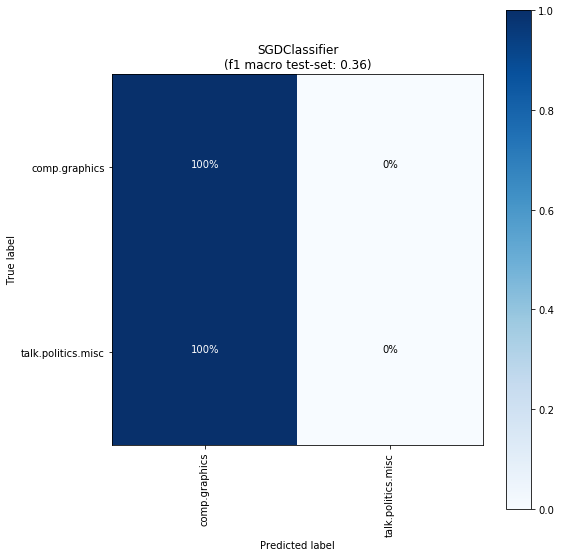

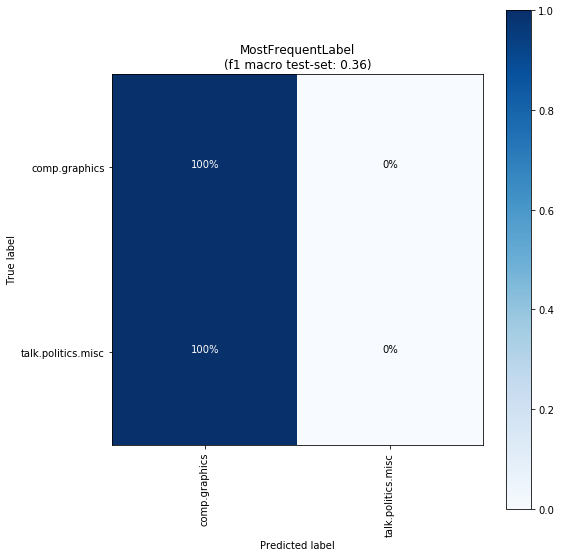

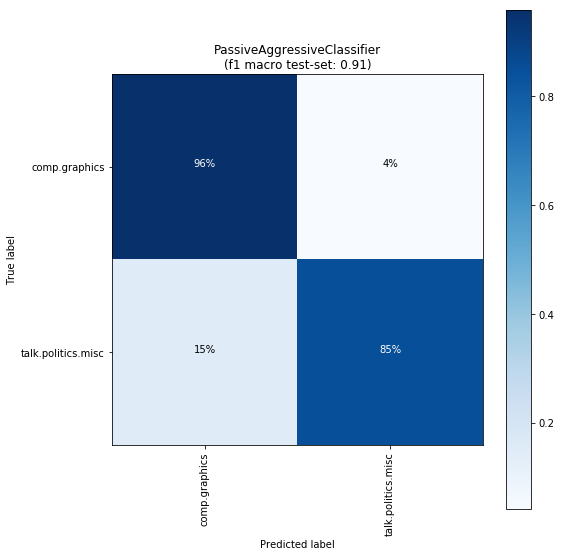

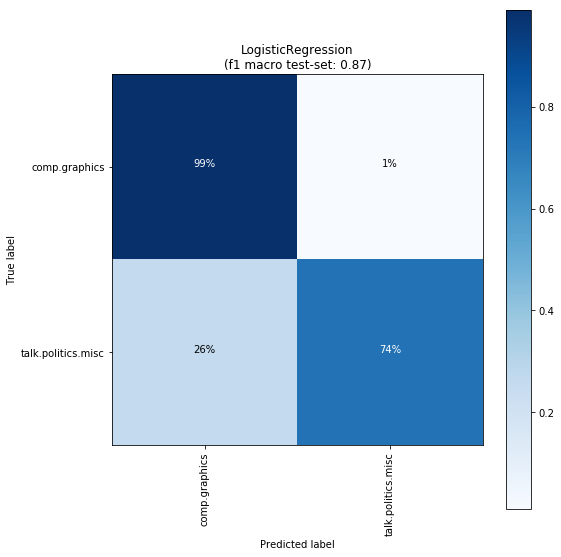

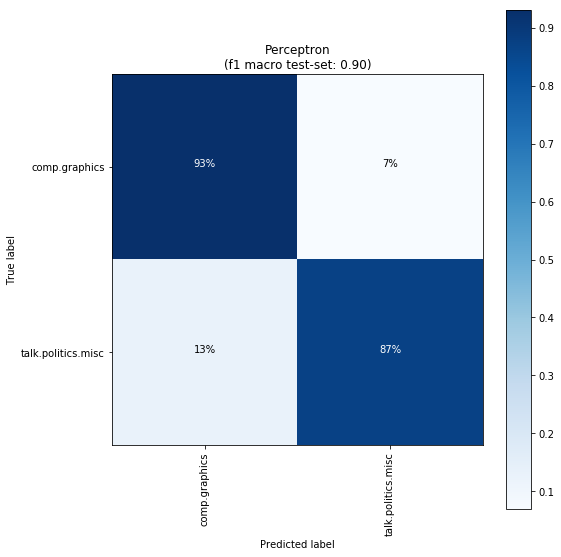

In [6]:
clfs = helper.get_classifiers()

results = {}
for clf_name, clf in clfs.items():
    print(clf_name)
    # Fit
    clf.fit(vectors_train, data_train_Y)
    
    # Predict
    pred_train = clf.predict(vectors_trans_train)
    pred_test = clf.predict(vectors_trans_test)
    
    # Metric
    f1_score_train = metrics.f1_score(data_train_Y, pred_train, average='macro')
    f1_score_test = metrics.f1_score(data_test_Y, pred_test, average='macro')
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test, 'acc': metrics.accuracy_score(data_test_Y, pred_test)}
    
    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(data_test_Y, pred_test, labels = classes)
    plt.figure(figsize = (8, 8))
    helper.plot_confusion_matrix(confusion_matrix, classes, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)
print('F1 Scores')
pd.DataFrame(results)
plt.show()

## Train Doc2Vec and Word2Vec classifier

### Pre-process docs for d2v and w2v

In [7]:
w2v_data = [w2v_d2v.w2v_preproess(doc) for doc in data_train_X]
w2v_data_test = [w2v_d2v.w2v_preproess(doc) for doc in data_test_X]

### Train Word2Vec

In [8]:
model_w2v = w2v_d2v.train_w2v(w2v_data, iterations=1)

### Train Doc2Vec

In [9]:
model_d2v = w2v_d2v.train_d2v(w2v_data, data_train_Y, iterations = 1)

In [10]:
scores = w2v_d2v.score_d2v(clfs, data_train_Y, data_test_Y, data_test_Y_names, model_d2v, w2v_data, w2v_data_test, steps = 1)

NameError: name 'data_test_Y_names' is not defined

In [ ]:
scores